In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
from matplotlib.animation import FuncAnimation
plt.style.use(["science","bright","grid"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

In [44]:
def mutal_capacitance_adjacent_spheres(eps_r: float, np_radius1: float, np_radius2: float, np_distance: float)->float:

    d       = (np_radius1 + np_radius2 + np_distance)
    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_r*(np_radius1*np_radius2)/d
    # Paper approx sum_val = 1
    sum_val = sum([1,(np_radius1*np_radius2)/(d**2-2*np_radius1*np_radius2),
                    ((np_radius1**2)*(np_radius2**2))/(d**4-4*(d**2)*np_radius1*np_radius2+3*(np_radius1**2)*(np_radius2**2))])
    cap     = factor*sum_val

    return np.round(cap,2)*1e-18

def self_capacitance_sphere(eps_s: float, np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_s
    cap     = factor*np_radius

    return np.round(cap,2)*1e-18

R   = 25*1e6
Cm  = mutal_capacitance_adjacent_spheres(2.6, 10, 10, 1)
Cs  = self_capacitance_sphere(3.9, 10)

## DC Input - Voltage Distribution - Closed Circuit

In [155]:
folder  = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/"
# folder      = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/"
N_voltages  = 40000
U_0         = 0.02
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq      = pd.DataFrame([pot[N_p].iloc[38000:,:].mean().values / U_0 for N_p in N_vals],index=N_vals).T.round(2)

### Steady State

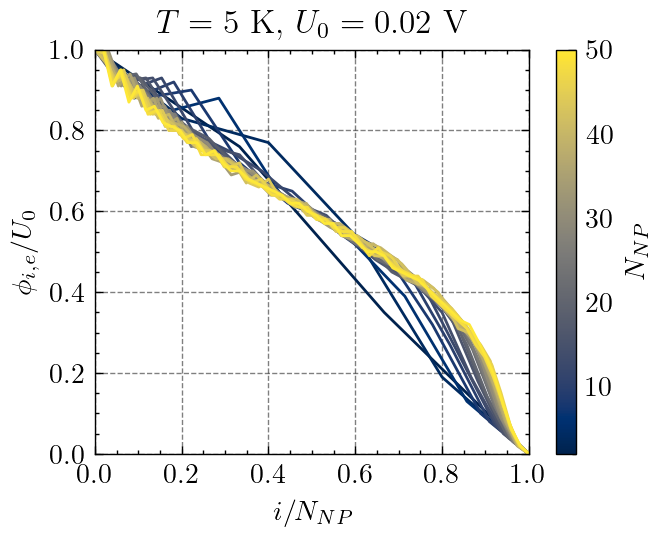

In [46]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    p   = np.append(p, 0.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_potential.svg", transparent=True)

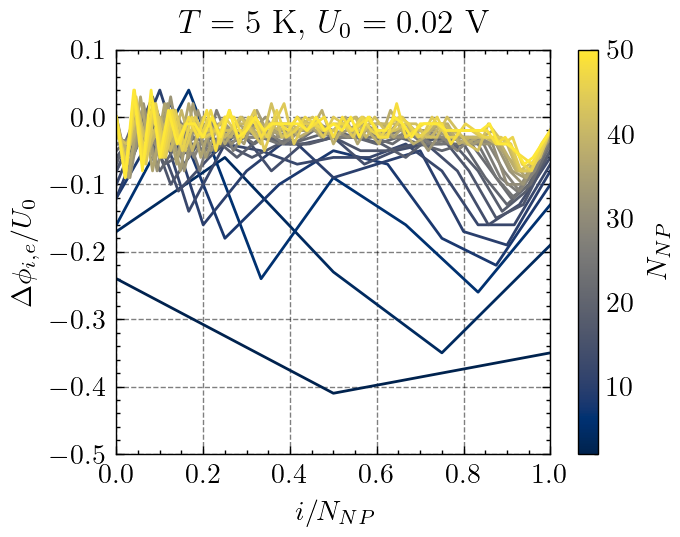

In [47]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    arr = pot_eq[N].dropna().values.copy()*U_0
    arr = np.insert(arr, 0, U_0)
    arr = np.append(arr, 0.0)
    arr = np.diff(arr)/U_0
    x   = np.linspace(0,1,len(arr))

    ax.plot(x, arr, color=cm(norm(N)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(0,1)
ax.set_ylim(-0.5, 0.1)
ax.set_ylabel("$\Delta \phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_potential_difference.svg", transparent=True)

There are three distinct regions:
- Alternating Pattern (First NPs)
  - Electrons tunneling into the string repel each other, creating **oscillatory potentials**
  - Example:
    - NP0 charges to $\phi_0 \approx U_0$
    - NP1 receives an electron, lowering $\phi_1$ slightly compared to $\phi_0$
    - NP2 then sees a reduced bias, leading to $\phi_2 > \phi_1$
  - **Standing charge wave**, where single-electron hops create local potential minima/maxima
- Quasi-Linear Decay (Middle NPs)
  - ***Averaging over many charge hops***
    - As charges propagate, the discreteness effects smear out, resembling a linear response but at **quanized steps**
    - The slope $d\phi / dk$ reflects the **effective resistance** per NP
- Rapid Drop (Last NPs)
  - The grounded electrode strongly attracts electrons, accelerating the drop in $\phi_k$
  - Charges near the end tunnel more frequently due to the larger $\Delta \phi$

### Characteristic Time Scale

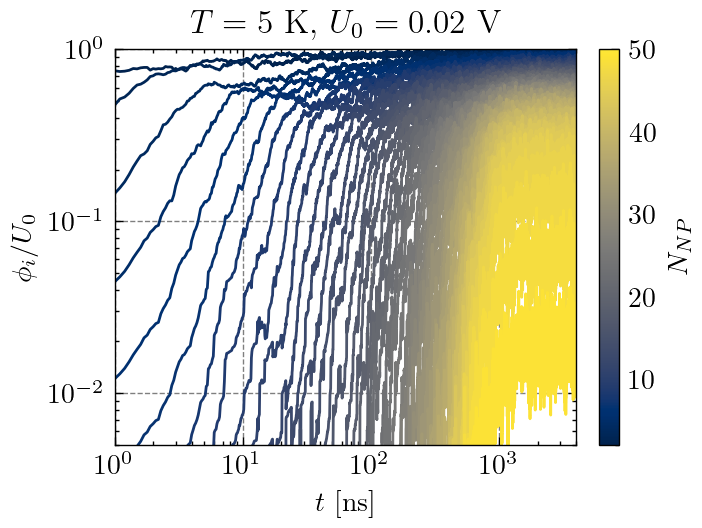

In [48]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))
Np      = 50

for i in range(Np):
    ax.plot(t_vals, pot[Np][f"{i}"].values/U_0, color=cm((i)/Np))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,4000)
ax.set_ylim(0.005,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_time_series.svg", transparent=True)

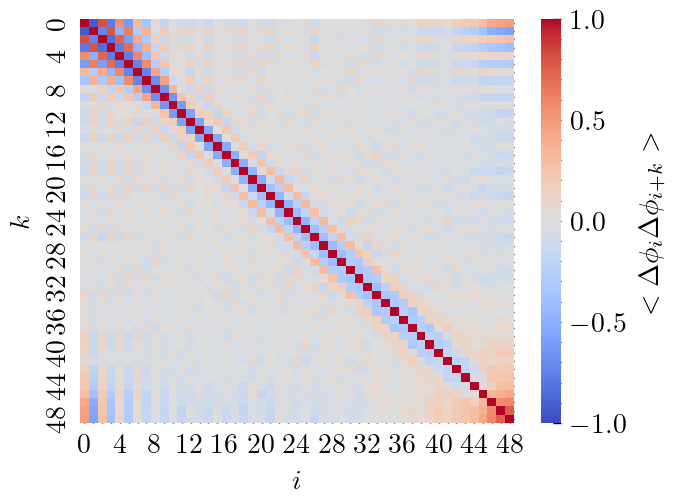

In [49]:
Np      = 50
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax, cbar_kws={"label":"$<\Delta\phi_i\Delta\phi_{i+k}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_pot_diff_corr.svg", transparent=True)

- Alternating correlation signals local charge-density waves:
  - Electrons repel each other, creating a quasi-ordered pattern
  - Perfect order (Wigner crystallization) is disturbed due to thermal fluctuations and finite bias given $U_0$
- As the grounded electrode drains charges, we get enhancing correlations in the last few NPs

Text(0, 0.5, '$C(k)$')

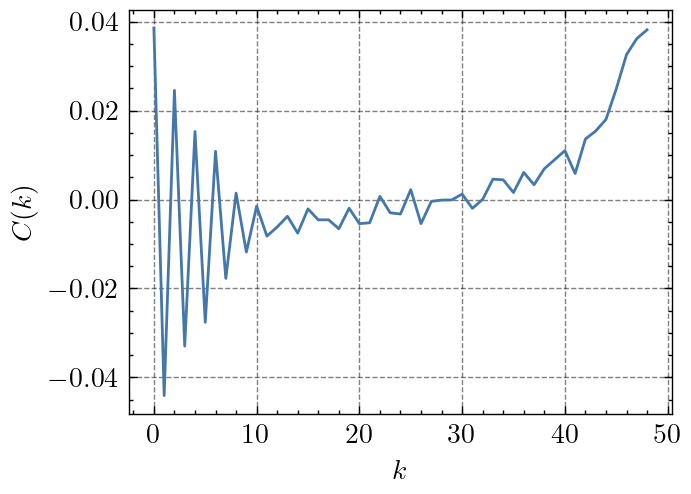

In [50]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(delta_p.corr().mean())
ax.set_xlabel("$k$")
ax.set_ylabel("$C(k)$")

# fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_pot_diff_corr_mean.svg", transparent=True)

In [51]:
def characteristic_time(t_vals, pot_df, Np, steady_start=20000, consecutive_points=50, p_th=0.63):

    end_vals    = pot_df[Np].iloc[steady_start:,:].mean().values
    taus        = []
    p_th        = 0.63

    for i in range(Np):
        vals        = pot_df[Np].loc[:,f'{i}'].values
        threshold   = p_th*end_vals[i]
        above_th    = vals > threshold
        for j in range(len(above_th) - consecutive_points):
            if all(above_th[j:j+consecutive_points]):
                tau = t_vals[j]
                taus.append(tau)
                break
    
    return taus

def characteristic_time_saturation(t_vals, pot_df, Np):

    def saturation_cuve(t, tau, a0, t0):
        return a0*(1 - np.exp(-(t-t0) / tau))

    tau = []
    std = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, cov  = curve_fit(saturation_cuve, x, y, bounds=((0,0,0),(np.inf,np.inf,np.inf)))
        tau.append(p[0])
        std.append(np.sqrt(cov[0,0]))

    return tau, std

def characteristic_time_stretched_saturation(t_vals, pot_df, Np, p0=None):

    def stretched_saturation_curve(t, tau, a0, beta):
        return a0*(1 - np.exp(-((t/tau)**beta)))

    tau = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, cov  = curve_fit(stretched_saturation_curve, x, y, p0=p0, bounds=((0,0,0),(np.inf,np.inf,np.inf)), maxfev=5000)
        tau_val = gamma(1/p[2])*p[0]/p[2]
        tau.append(tau_val)
        # print(p)

    return tau

In [68]:
Np                                  = 50
taus_hot, std_hot                   = characteristic_time_saturation(t_vals, pot, Np)
# taus_hot_stretched, params_streched = characteristic_time_stretched_saturation(t_vals, pot, Np, p0=[50,1,1])

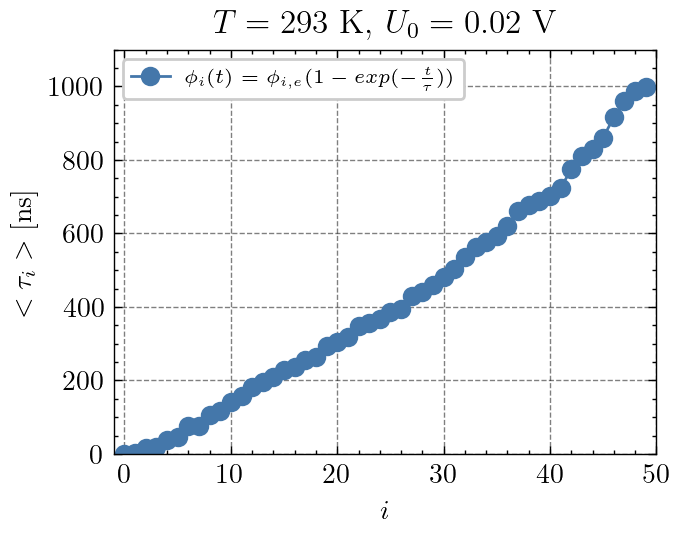

In [69]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, taus_hot, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
# ax.plot(xp, taus_hot_stretched, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
ax.set_ylim(0,1100)
ax.set_xlim(-1,50)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_time_scales.svg", transparent=True)

In [70]:
tau_s               = []
tau_s_stretched     = []

for Np in N_vals:
    taus, std   = characteristic_time_saturation(t_vals, pot, Np)
    tau_s.append(np.max(taus))
    # taus        = characteristic_time_stretched_saturation(t_vals, pot, Np)
    # tau_s_stretched.append(taus)

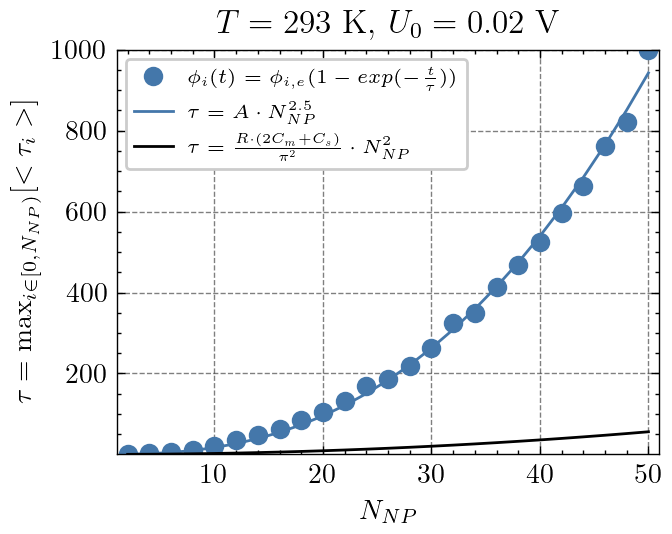

In [75]:
def quad_func(x, a):
    return a*x**2

def pol_func(x, a, b):
    return a*x**b

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(pol_func, N_vals, tau_s)
pp  = ax.plot(N_vals, tau_s, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, pol_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^{"+f"{np.round(p[1],2)}"+"}$")

# p,_ = curve_fit(quad_func, N_vals, tau_s_stretched)
# pp  = ax.plot(N_vals, tau_s_stretched, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
# ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

ax.plot(N_vals, quad_func(np.array(N_vals), R*(2*Cm+Cs)*1e9 / (np.pi**2)), color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
ax.set_ylim(1,1000)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
# ax.set_xscale('log')
# ax.set_yscale('log')

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_time_scales_vs_N.svg", transparent=True)

- Charges move via **rare, stochastic hops** (like a random walk with waiting times)
- Each hop requires overcoming Coulomb repulsion from neighboring charges: **Barrier accumulation**
- Charges cannot overtake, creating bottlenecks: **Single-file motion**
- **Fractional diffusion:**
  - In classical diffusion, displacement $\Delta x ~ \sqrt{t}$
  - Now disorder and interactions slow propagation, leading to $\Delta x ~ t^{1/2.5} \rightarrow \tau ~ N^{2.5}$ --> **Subdiffusion**

In [62]:
p

array([0.05286799, 2.50219818])

In [77]:
Cs

4.34e-18

In [81]:
e   = 1.60217663*10**(-19)
kB  = 1.380649*10**(-23)
a   = np.exp(e**2 / ((2*Cm+Cs)*kB*5))
a

2.0407234118068188e+18

In [67]:
a_fit = p[0]*1e9
a_fit

52867987.46721558

Text(0.5, 0, '$t$ [ns]')

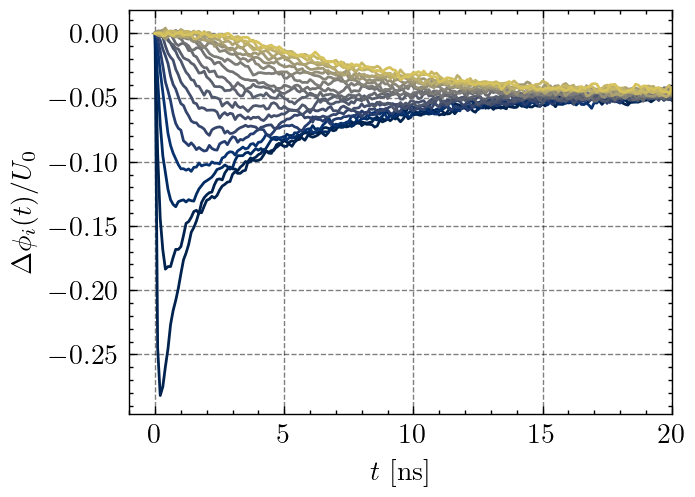

In [8]:
Np      = 20
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot_hot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0_hot, color=cm((i-1)/Np), label=f'${i}$')
ax.set_xlim(-1,20)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")
# ax.legend(fontsize='x-small', ncol=2)

Text(0.5, 0, '$t$ [ns]')

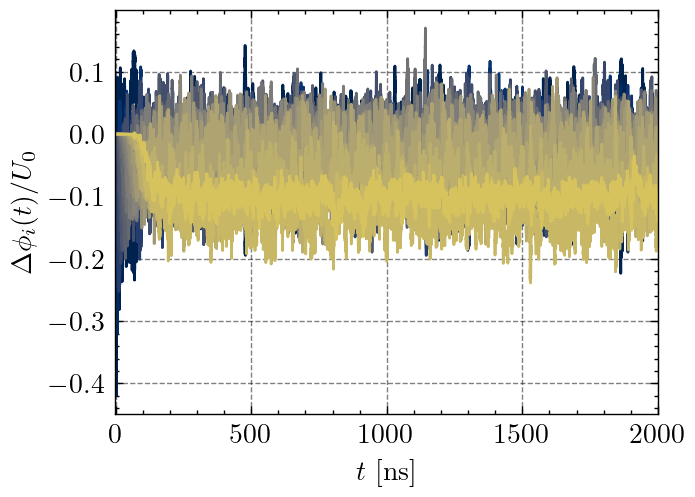

In [9]:
Np      = 20
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot_cold[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0_cold, color=cm((i-1)/Np))
ax.set_xlim(-1,2000)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")
# ax.legend(fontsize='x-small')

In [10]:
# from scipy.interpolate import griddata
# from scipy.signal import savgol_filter

# Np              = 20
# i               = 15
# stop            = 1000
# t               = t_vals.copy()[:stop]
# y               = pot_cold[Np][f"{i}"].copy().values[:stop]/U_0_cold
# # y               = pot_hot[Np][f"{i}"].copy().values[:stop]/U_0_hot
# window_size     = 41
# dy_dt_smooth    = savgol_filter(y, window_size, polyorder=2, deriv=1, delta=t[1]-t[0])
# dy_dt           = dy_dt_smooth
# y_grid          = np.linspace(min(y), max(y), 100)
# dy_grid         = np.linspace(min(dy_dt), max(dy_dt), 100)
# Y, DY           = np.meshgrid(y_grid, dy_grid)
# dY_grid         = griddata((y, dy_dt), dy_dt, (Y, DY), method='linear')  # dy/dt
# dDY_grid        = griddata((y, dy_dt), np.gradient(dy_dt, t), (Y, DY), method='linear')  # d²y/dt²

# # Plot phase space with streamplot
# fig     = plt.figure(dpi=200)
# ax      = fig.add_subplot()
# strm    = ax.streamplot(
#         Y, DY, dY_grid, dDY_grid,
#         arrowsize=1,              # Larger arrows
#         arrowstyle='->',            # Arrow style
#         density=1.0,                # Higher density of lines
#         maxlength=2000,             # Longer trajectories
#         integration_direction='both'  # Integrate forward/backward
# )
# ax.set_xlabel("$\phi(t)$")
# ax.set_ylabel("$\dot{\phi}(t)$")

# Np      = 20
# i       = 10
# start   = 10000
# t       = t_vals.copy()[start:]
# # y       = pot_hot[Np][f"{i}"].copy().values[start:]/U_0_hot
# dy_dt   = np.gradient(y, t)
# y       = pot_cold[Np][f"{i}"].copy().values[start:]/U_0_cold
# fig     = plt.figure(dpi=200)
# ax      = fig.add_subplot()
# im      = ax.hist2d(y, dy_dt, bins=[100,100], cmap='cividis', range=[[0,1],[-1,1]])
# # im      = ax.hexbin(y, dy_dt_smooth, gridsize=100, cmap='cividis', mincnt=1)
# cb      = fig.colorbar(im[3], label='Density', ax=ax)
# ax.set_xlabel("$\phi(t)$")
# ax.set_ylabel("$\dot{\phi}(t)$")
# # fixed_points_mask = np.abs(dy_dt_smooth) < 0.01 * np.max(dy_dt_smooth)  # Threshold
# # ax.scatter(
# #     y[fixed_points_mask], 
# #     dy_dt_smooth[fixed_points_mask], 
# #     color='red', 
# #     s=5, 
# #     alpha=0.5,
# #     label='Fixed points'
# # )
# # plt.xlabel('y(t)')
# # plt.ylabel('dy/dt')

# # plt.hexbin(y, dy_dt_smooth, gridsize=100, cmap='cividis', mincnt=1)

In [11]:
# fig = plt.figure(dpi=200, layout='constrained')
# fig.set_figwidth(fig.get_figwidth()*2)
# ax      = fig.add_subplot(1,2,1)
# cm      = plt.get_cmap('cividis')
# taus    = []
# taus1   = []
# taus2   = []
# betas   = []
# starts  = [10,10,10,10,20,20,20,20,30,30,30,30,40,40,40,40,50,50,50,50]
# starts  = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]

# for i in range(Np):
#     x, y    = t_vals[starts[i]:500], pot_hot[Np][f"{i}"].values[starts[i]:500]/U_0_hot
#     p,c     = curve_fit(stretched_saturation_curve, x, y, maxfev=10000, p0=[1,1,1], bounds=[(0,0,0),(10,1,2)])#, p0=[1,5,1.0,0.0,0.0], bounds=[(0,0,0,0,0),(10,10,1,2,2)])
#     taus.append(p[0])
#     taus1.append(p[0])
#     taus2.append(p[1])
#     betas.append(p[2])
#     print(p)

#     ax.plot(x, y, color=cm((i+1)/Np), ms=4)#, marker='.')
#     ax.plot(x, stretched_saturation_curve(x, *p), color=cm((i+1)/Np), ls='--')

# tau = gamma(1/np.array(betas))*np.array(taus)/np.array(betas)
# ax.set_xlim(1,50)
# # ax.set_ylim(0.001,1)
# ax.set_ylim(0.01,1)
# ax.set_ylabel("$\phi_i / U_0$")
# ax.set_xlabel("$t$ [ns]")
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")

# ax  = fig.add_subplot(1,2,2)
# ax.plot(range(Np), tau, 'o-', label='$<\\tau> = \\frac{\\tau}{\\beta} \cdot \Gamma(\\frac{1}{\\beta})$')
# # ax.plot(range(Np), taus1, 'o-', label='$\\tau_1$')
# # ax.plot(range(Np), taus2, 'o-', label='$\\tau_2$')
# ax.set_ylabel('$<\\tau_i>$ [ns]')
# ax.set_xlabel("$i$")
# ax.set_ylim(0,10)
# ax.set_xlim(-1,20)
# ax.set_title("$\phi \propto U_0 \cdot (1 - e^{-(t/\\tau)^{\\beta}})$")
# ax.legend(fontsize='small')

# fig.savefig("../plots/dc_input/closed_circuit_room_temp_fit.svg", transparent=True)

In [12]:
# current_cold    = {N_p : pd.read_csv(f"{folder_cold}Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
# current_hot     = {N_p : pd.read_csv(f"{folder_hot}Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}

In [13]:
# fig = plt.figure(dpi=200, layout='constrained')
# fig.set_figwidth(fig.get_figwidth()*2)
# ax1 = fig.add_subplot(1,2,1)
# ax2 = fig.add_subplot(1,2,2)
# cm  = plt.get_cmap('cividis')
# Np  = 20

# for i in N_vals:
#     ax1.plot(t_vals, current_cold[i]['Current'].values, color=cm((i+1)/Np), marker='.', ms=2)
#     ax1.fill_between(t_vals, current_cold[i]['Current'].values-current_cold[i]['Error'].values,
#                      current_cold[i]['Current'].values+current_cold[i]['Error'].values, color='black', alpha=0.2)
#     ax2.plot(t_vals, current_hot[i]['Current'].values, color=cm((i+1)/Np), marker='.', ms=2)
#     ax2.fill_between(t_vals, current_hot[i]['Current'].values-current_hot[i]['Error'].values,
#                      current_hot[i]['Current'].values+current_hot[i]['Error'].values, color='black', alpha=0.2)

# ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
# ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
# ax1.set_xlabel("$t$ [ns]")
# ax1.set_xlim(1,4000)
# ax2.set_xlim(1,4000)
# # ax1.set_ylim(0.0001,10000)
# # ax2.set_ylim(10,100000)
# # ax1.set_yscale('log')
# # ax2.set_yscale('log')
# ax1.set_xscale('log')
# ax2.set_xscale('log')
# ax1.set_ylabel("$I$ [pA]")
# ax1.set_xlabel("$t$ [ns]")
# ax2.set_ylabel("$I$ [pA]")
# ax2.set_xlabel("$t$ [ns]")

## DC Input - Voltage Distribution - Open Circuit

In [166]:
folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/"
# folder  = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/"
N_voltages  = 40000
U_0         = 0.02
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq      = pd.DataFrame([pot[N_p].iloc[38000:,:].mean().values / U_0 for N_p in N_vals],index=N_vals).T.round(2)

In [167]:
pot[40]

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.007601,0.002072,0.000565,0.000154,0.000042,0.000011,0.000003,8.503160e-07,2.317984e-07,6.318885e-08,...,8.846497e-20,2.411578e-20,6.574026e-21,1.792097e-21,4.885306e-22,1.331758e-22,3.630782e-23,9.911398e-24,2.752463e-24,9.359110e-25
1,0.009574,0.003389,0.000924,0.000252,0.000069,0.000019,0.000005,1.390836e-06,3.791454e-07,1.033560e-07,...,1.446994e-19,3.944544e-20,1.075293e-20,2.931277e-21,7.990744e-22,2.178315e-22,5.938758e-23,1.621177e-23,4.502119e-24,1.530841e-24
2,0.011140,0.003983,0.001183,0.000323,0.000088,0.000024,0.000007,1.781495e-06,4.856403e-07,1.323868e-07,...,1.853428e-19,5.052493e-20,1.377323e-20,3.754619e-21,1.023519e-21,2.790163e-22,7.606844e-23,2.076535e-23,5.766681e-24,1.960825e-24
3,0.012540,0.004991,0.001458,0.000398,0.000108,0.000030,0.000008,2.195172e-06,5.984096e-07,1.631280e-07,...,2.283808e-19,6.225720e-20,1.697148e-20,4.626469e-21,1.261188e-21,3.438059e-22,9.373210e-23,2.558722e-23,7.105747e-24,2.416144e-24
4,0.013695,0.005866,0.001697,0.000463,0.000126,0.000034,0.000009,2.554362e-06,6.963259e-07,1.898203e-07,...,2.657501e-19,7.244419e-20,1.974848e-20,5.383487e-21,1.467553e-21,4.000620e-22,1.090693e-22,2.977399e-23,8.268443e-24,2.811491e-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39994,0.022899,0.016139,0.022070,0.016373,0.021674,0.016370,0.021341,1.649267e-02,2.144018e-02,1.640391e-02,...,2.117154e-02,1.549934e-02,2.127789e-02,1.568269e-02,2.117748e-02,1.582027e-02,2.074513e-02,1.612875e-02,2.024326e-02,1.455906e-02
39995,0.022901,0.016144,0.022091,0.016450,0.021597,0.016349,0.021335,1.649057e-02,2.143778e-02,1.639654e-02,...,2.124830e-02,1.552026e-02,2.128359e-02,1.568425e-02,2.117791e-02,1.582039e-02,2.074517e-02,1.612876e-02,2.024326e-02,1.455906e-02
39996,0.022902,0.016150,0.022112,0.016527,0.021521,0.016328,0.021329,1.648902e-02,2.143736e-02,1.639643e-02,...,2.124830e-02,1.552026e-02,2.128359e-02,1.568425e-02,2.117791e-02,1.582039e-02,2.074517e-02,1.612876e-02,2.024326e-02,1.455906e-02
39997,0.022902,0.016150,0.022112,0.016527,0.021522,0.016334,0.021350,1.656577e-02,2.136061e-02,1.637551e-02,...,2.132494e-02,1.544308e-02,2.126112e-02,1.567284e-02,2.115543e-02,1.574321e-02,2.082181e-02,1.614968e-02,2.024907e-02,1.456103e-02


In [168]:
cap_matrix          = {}
inv_cap_matrix      = {}
for N_p in N_vals:
    topology_parameter  = {
        "Nx"                : N_p,
        "Ny"                : 1,
        "Nz"                : 1,
        "e_pos"             : [[0,0,0],[N_p-1,0,0]],
        "electrode_type"    : ['constant','floating']
    }
    sim_class           = nanonets.simulation(topology_parameter=topology_parameter, high_C_output=False)
    cap_matrix[N_p]     = sim_class.capacitance_matrix
    inv_cap_matrix[N_p] = sim_class.inv_capacitance_matrix

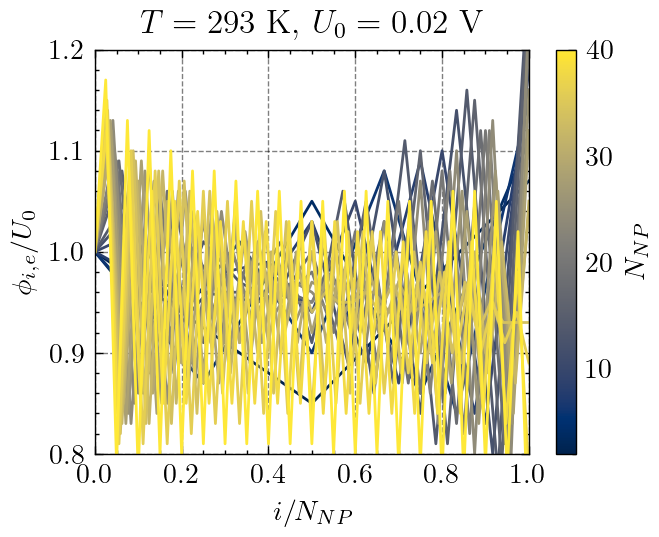

In [169]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_ylim(0.8,1.2)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_potential.svg", transparent=True)

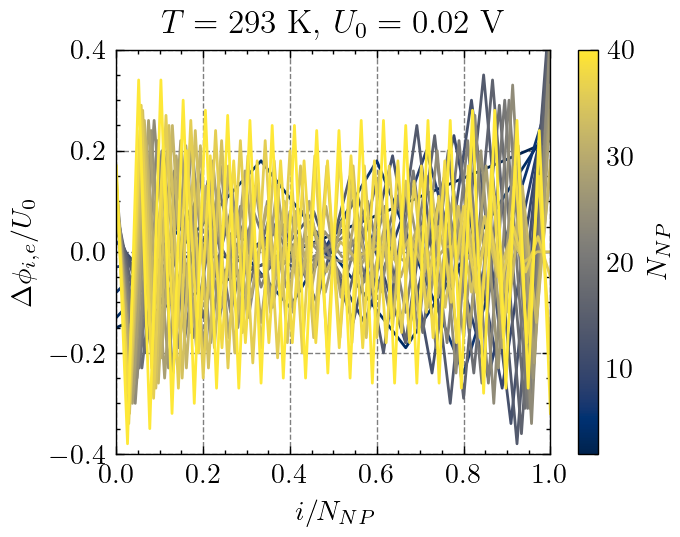

In [170]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    arr = pot_eq[N].dropna().values.copy()*U_0
    arr = np.insert(arr, 0, U_0)
    arr = np.diff(arr)/U_0
    x   = np.linspace(0,1,len(arr))

    ax.plot(x, arr, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(0,1)
ax.set_ylim(-0.4, 0.4)
ax.set_ylabel("$\Delta \phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_potential_difference.svg", transparent=True)

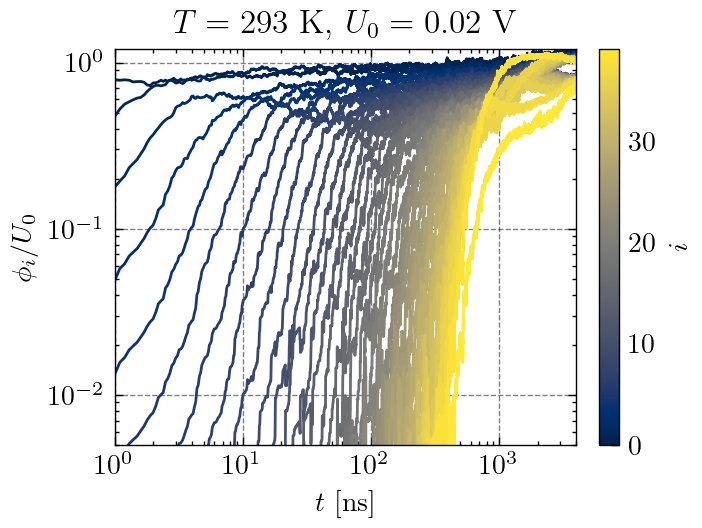

In [171]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
Np      = 40
norm    = Normalize(vmin=0, vmax=Np-1)

for i in range(Np):
    ax.plot(t_vals, pot[Np][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,4000)
ax.set_ylim(0.005,1.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_time_series.svg", transparent=True)

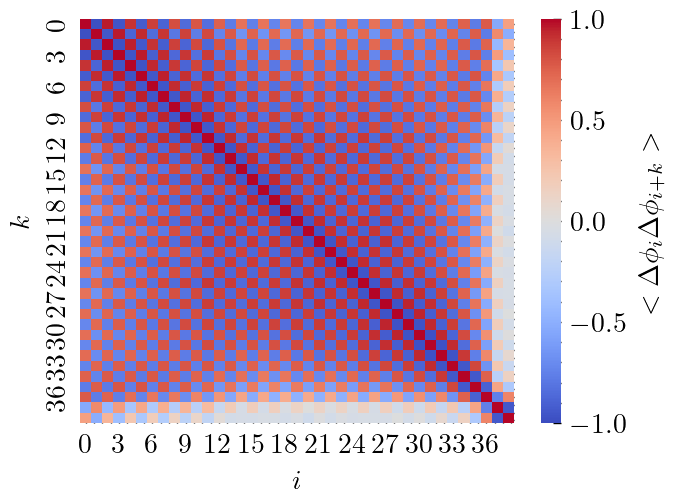

In [175]:
Np      = 40
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax, cbar_kws={"label":"$<\Delta\phi_i\Delta\phi_{i+k}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_pot_diff_corr.svg", transparent=True)

Text(0, 0.5, '$C(k)$')

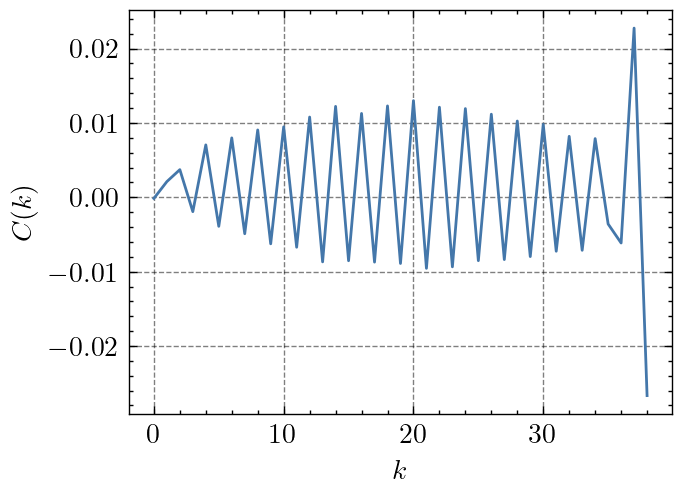

In [177]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(delta_p.corr().mean(axis=1))
ax.set_xlabel("$k$")
ax.set_ylabel("$C(k)$")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_pot_diff_corr_mean.svg", transparent=True)

In [178]:
Np                  = 40
taus_hot, std_hot   = characteristic_time_saturation(t_vals, pot, Np)
# taus_hot_stretched  = characteristic_time_stretched_saturation(t_vals, pot, Np, p0=[5,1,1])

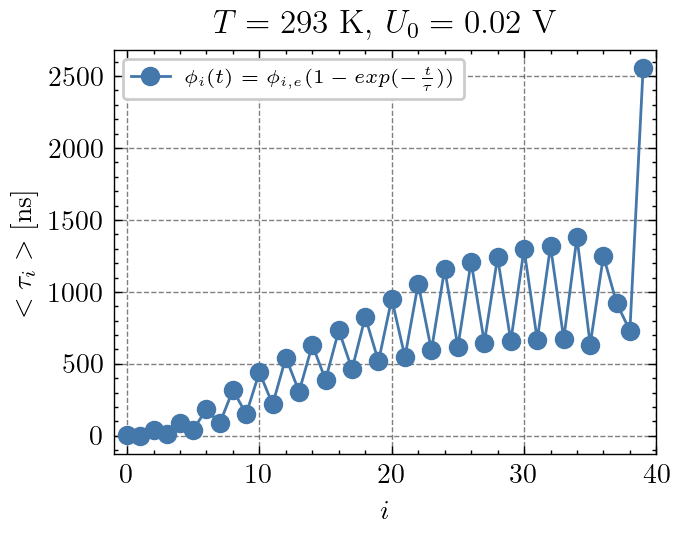

In [180]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, taus_hot, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
# ax.plot(xp, taus_hot_stretched, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
# ax.set_ylim(0,200)
ax.set_xlim(-1,40)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_time_scales.svg", transparent=True)

In [ ]:
tau_s               = []
tau_s_stretched     = []

for Np in N_vals:
    taus, std   = characteristic_time_saturation(t_vals, pot, Np)
    tau_s.append(np.max(taus))
    # taus        = characteristic_time_stretched_saturation(t_vals, pot, Np)
    # tau_s_stretched.append(np.max(taus))

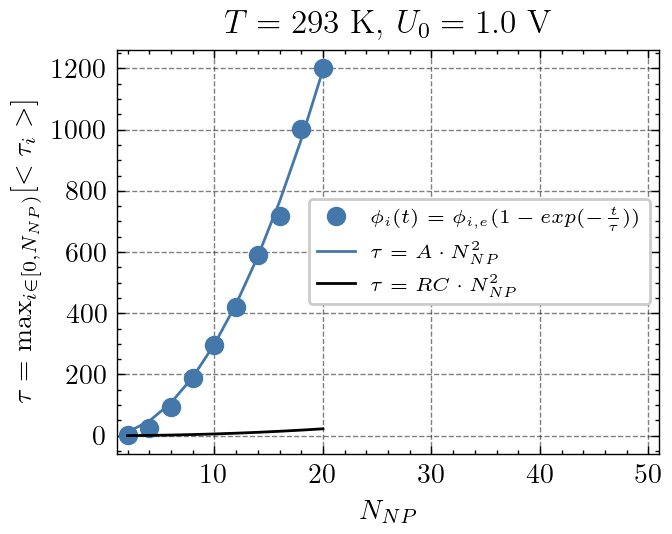

In [99]:
def quad_func(x, a):
    return a*x**2

def pol_func(x, a, b):
    return a*x**b

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(quad_func, N_vals, tau_s)
pp  = ax.plot(N_vals, tau_s, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

# p,_ = curve_fit(quad_func, N_vals, tau_s_stretched)
# pp  = ax.plot(N_vals, tau_s_stretched, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
# ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

ax.plot(N_vals, quad_func(np.array(N_vals), R*Cm*1e9), color='black', label="$\\tau = RC \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
# ax.set_ylim(0,60)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_time_scales_vs_N.svg", transparent=True)

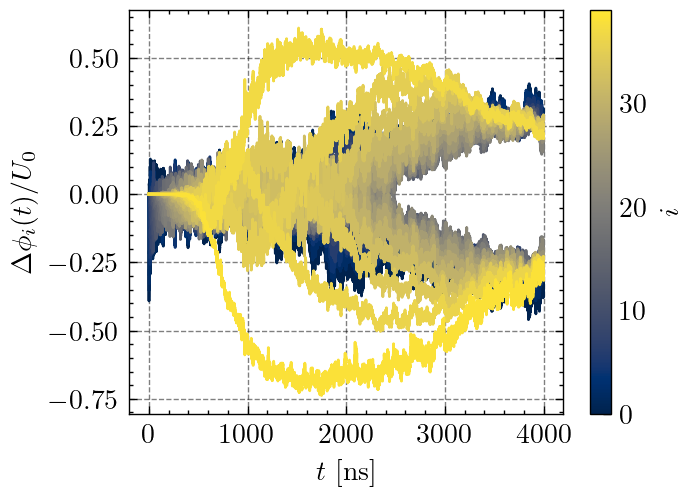

In [181]:
Np      = 40
norm    = Normalize(vmin=0, vmax=(Np-1))
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0, color=cm(norm(i)), label=f'${i}$')
# ax.set_xlim(-1,100)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# ax.legend(fontsize='x-small', ncol=2)

In [182]:
Np  = 40
Q_t = np.zeros_like(pot[Np].values)
C   = cap_matrix[Np]
C_i = inv_cap_matrix[Np]
for t in range(pot[Np].values.shape[0]):
    Q_t[t, :] = C @ pot[Np].values[t, :]

# Total injected charge (relative to t=0)
Q_total = np.sum(Q_t - Q_t[0, :], axis=1)  # Shape: (N_T,)
P       = Q_t[-1, 1:] - Q_t[-1, :-1]

E_t = np.zeros(pot[Np].values.shape[0])
for t in range(pot[Np].values.shape[0]):
    E_t[t] = 0.5 * Q_t[t, :].T @ C_i @ Q_t[t, :]

Text(0, 0.5, '$P_i$')

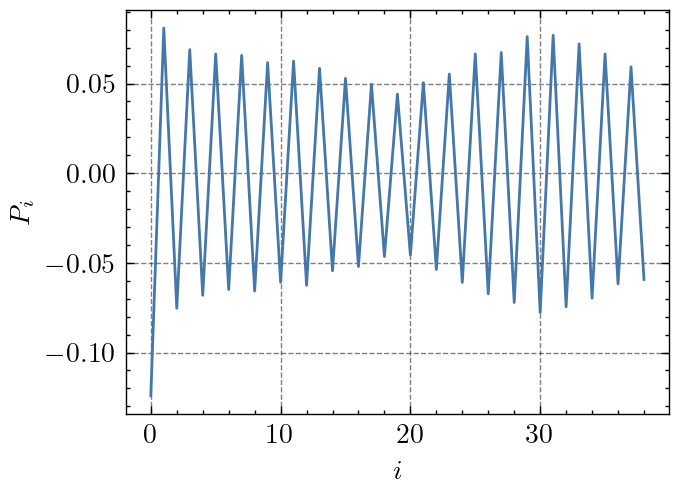

In [185]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(P)
ax.set_xlabel("$i$")
ax.set_ylabel("$P_i$")

Text(0, 0.5, '$Q_{total}$ [C]')

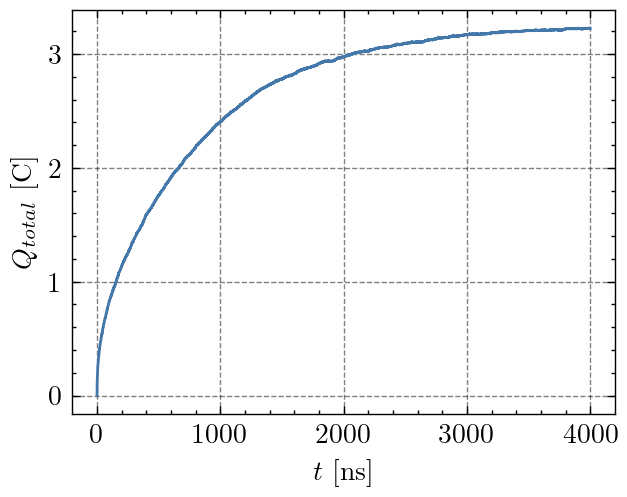

In [192]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t_vals,Q_total)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$Q_{total}$ [C]")

Text(0, 0.5, '$E$ [J]')

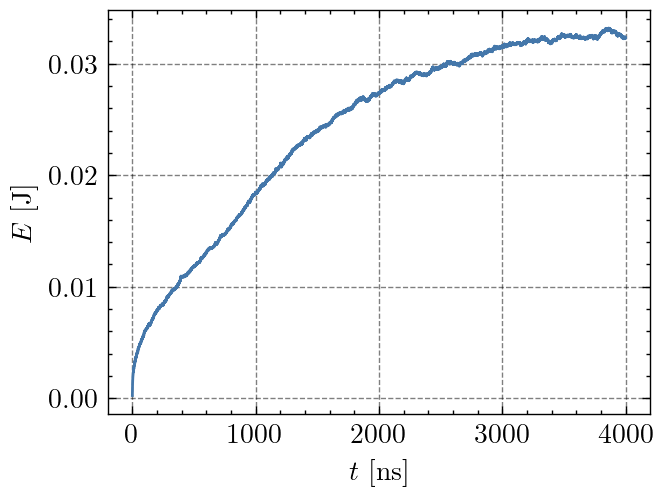

In [193]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t_vals,E_t)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$E$ [J]")

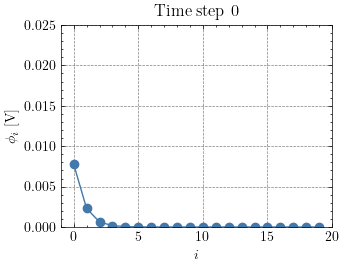

In [207]:
Np      = 20
p_anni  = pot[Np].values.copy()[:5000,:]
fig, ax = plt.subplots()
ax.set_xlabel('$i$')
ax.set_ylabel('$\phi_i$ [V]')
ax.set_ylim(np.min(pot[Np].values), np.max(pot[Np].values))
ax.set_xlim(-1, Np)
line, = ax.plot([], [], 'o-')

def update(frame):
    line.set_data(np.arange(Np), pot[Np].values[frame, :])
    ax.set_title(f'Time step {frame}')
    return line,

ani = FuncAnimation(fig, update, frames=pot[Np].values.shape[0], interval=10, blit=True)

In [ ]:
ani.save("test.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


---